In [3]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime
from dateutil.relativedelta import relativedelta
from math import log
import csv
import string 




[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Correlation between the weighted price index and PILANIINVS.NS: 0.95


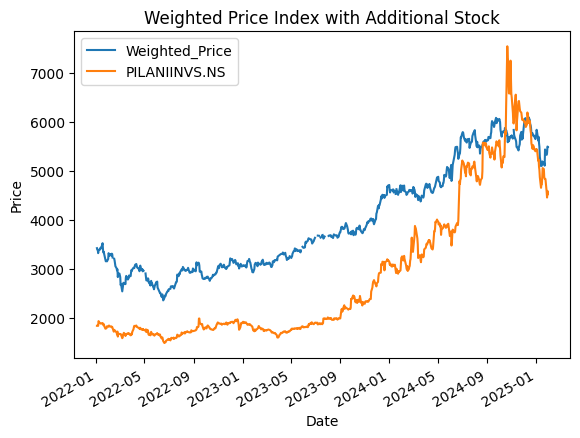

[*********************100%%**********************]  1 of 1 completed


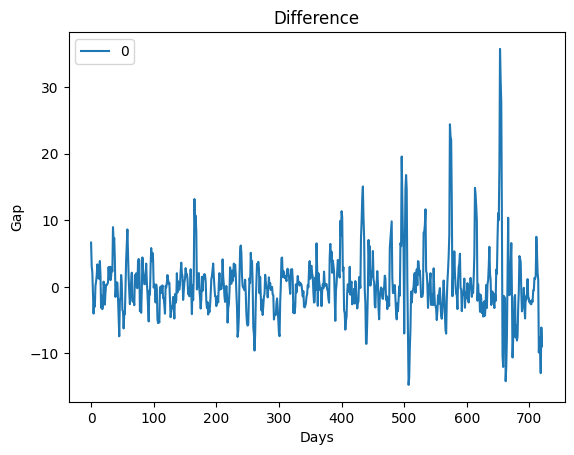

-5098.190846420272
     Position        Price
0         Buy  3420.697676
1    Buy Main  1838.550659
2        Sell  3319.167152
3   Sell Main  1837.373047
4         Buy  2966.903344
..        ...          ...
79  Sell Main  5598.500000
80        Buy  5539.664496
81   Buy Main  6264.399902
82       Sell  5735.527186
83  Sell Main  6037.850098

[84 rows x 2 columns]
Mean:  0.3154400149694591 Variance:  4.8757390798247


In [4]:




def fetch_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data['Adj Close']

def calculate_weighted_price(stock_data_dict, weights):
    return sum(stock_data * weight for stock_data, weight in zip(stock_data_dict.values(), weights))

def plot_weighted_price_and_correlation(stock_data_dict, weights, additional_stock_data, additional_stock_label):
    # Calculate the weighted price
    weighted_price = calculate_weighted_price(stock_data_dict, weights)
    
    # Create a DataFrame with both series
    df = pd.DataFrame({'Weighted_Price': weighted_price, additional_stock_label: additional_stock_data})

    # Calculate correlation using Pandas
    correlation = df.corr().loc['Weighted_Price', additional_stock_label]
    print(f'Correlation between the weighted price index and {additional_stock_label}: {correlation:.2f}')

    # Plot the data
    df.plot()
    plt.title('Weighted Price Index with Additional Stock')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

def plot_return_gap(stock_data_dict, additional_stock_label, weights, start_date, end_date):
    holding_returns = log_returns(stock_data_dict, weights, 1, start_date, end_date)
    main_company_returns = log_returns(additional_stock_label, weights, 0, start_date, end_date)
    list = []
    for i in range(len(holding_returns)):
        if str(holding_returns[i]-main_company_returns[i]) != 'nan':
            list.append(main_company_returns[i]-holding_returns[i])
        else: continue
    #print(list)
    #print(sorted(list))
    # Plot the weighted price index with the additional stock and calculate correlation
    data = pd.DataFrame(list)
    data.plot()
    plt.title('Difference')
    plt.xlabel('Days')
    plt.ylabel('Gap')
    plt.legend()
    plt.show()
    return list

def log_returns(stock_data_dict, weights, isIndex, start_date, end_date):
    log_price = []
    if isIndex == 1:
        price_data = list(calculate_weighted_price(stock_data_dict, weights).values)
    else:
        price_data = list(yf.download(stock_data_dict, start=start_date, end=end_date)['Adj Close'].values)
    for i in range(4, len(price_data)):
        log_price.append(((price_data[i]/price_data[i-4])-1)*100)
    return log_price

def trade_book():
    tradelog = pd.DataFrame(columns = ['Position', 'Price'])
    return tradelog

def entry_exit(list, main_company_price_data, holding_price_data):
    tradebook = trade_book()
    max=0
    for i in range(len(list)):
        if max == 0:
            if list[i]>np.std(list)+1:
                max = 1
                tradebook.loc[len(tradebook)] = ["Buy", holding_price_data[i]]
                tradebook.loc[len(tradebook)] = ["Buy Main", main_company_price_data[i]]
        if max == 1 :
            if list[i]<np.mean(list):
                tradebook.loc[len(tradebook)] = ["Sell", holding_price_data[i]]
                tradebook.loc[len(tradebook)] = ["Sell Main", main_company_price_data[i]]
                max = 0
    return tradebook     

def pnl(tradebook, list, main_company_price_data, holding_price_data):
    tradebook = entry_exit(list, main_company_price_data, holding_price_data)
    buying = tradebook.loc[tradebook['Position'] == 'Buy']['Price'].sum() + tradebook.loc[tradebook['Position'] == 'Buy Main']['Price'].sum()
    selling = tradebook.loc[tradebook['Position'] == 'Sell']['Price'].sum() + tradebook.loc[tradebook['Position'] == 'Sell Main']['Price'].sum()
    print(selling-buying)
    
def main():
    # Define the stocks and their weights
    stocks = ['ABREL.NS', 'KESORAMIND.NS', 'MANGLMCEM.BO', 'ULTRACEMCO.BO', 'ABFRL.NS','IDEA.NS','PILANIINVS.NS']
    weights = [0.482, 0.087, 0.012, 0.391,0.010, 0.019]  # You can customize the weights as per your preference

    # User input for date range
    start_date = '2022-01-01'
    end_date = '2025-01-31'

    # Fetch stock data
    stock_data_dict = {ticker: fetch_stock_data(ticker, start_date, end_date) for ticker in stocks[:-1]}  # Exclude the last stock
    additional_stock_data = fetch_stock_data(stocks[-1], start_date, end_date)
    additional_stock_label = stocks[-1]
    holding_price_data = np.array(calculate_weighted_price(stock_data_dict, weights).values)
    main_company_price_data = np.array(fetch_stock_data(additional_stock_label, 
                                                        start_date, end_date))
    plot_weighted_price_and_correlation(stock_data_dict, weights, 
                                        additional_stock_data, 
                                        additional_stock_label)
    list= np.array(plot_return_gap(stock_data_dict, 
                                   additional_stock_label, weights, 
                                   start_date, end_date))
    tradebook = entry_exit(list, main_company_price_data, holding_price_data)
    pnl(tradebook, list, main_company_price_data, holding_price_data)
    print(tradebook)
    print("Mean: ", np.mean(list), "Variance: ", np.std(list))
if __name__ == "__main__":
    main()


## 